In [1]:
import keras

keras.__version__

Using TensorFlow backend.


'2.2.4'

## 8.4 변이형 오토인코더를 사용한 이미지 생성

### 8.4.1 이미지의 잠재 공간에서 샘플링하기

- 이미지 생성의 핵심 아이디어는 각 포인트가 실제와 같은 이미지로 매핑될 수 있는 저차원 잠재공간(latent space, 벡터공간)의 표현을 만드는 것이다.

- 잠재공간의 한 포인트를 입력으로 받아 이미지(픽셀의 그리드)를 출력하는 모듈을 **생성자**(generator) 또는 **디코더**(decoder)라고 부른다.


<img src="./images/img_gen.png" height="70%" width="70%"/>

- VAE는 구조적인 잠재공간을 학습하는 데 뛰어나다. 이 공간에서 특정 방향은 데이터에서 의미 있는 변화의 방향을 인코딩한다. 

- GAN은 매우 실제 같은 이미지를 만들면, 여기에서 만든 잠재공간은 구조적이거나 연속성이 없을 수 있다.

### 8.4.2 이미지 변형을 위한 개념 벡터

- 잠재공간이나 임베딩 공간이 주어지면 이 공간의 어떤 방향은 원본 데이터의 변화를 인코딩한 축일 수 있다. 
    - 예를 들어, 얼굴 이미지에 대한 잠재공간에 웃음 벡터가 있을 수 있다.
    - 잠재공간의 $z$ 포인트가 어떤 얼굴의 임베딩된 표현이라면 잠재공간의 $z + s$포인트는 같은 얼굴이 웃고 있는 표현을 임베딩한 것이다. 
    

- 이러한 벡터를 찾아내면 이미지를 잠재공간에 투영해서 의미 있는 방향으로 이 표현을 이동한 후 이미지 공간으로 디코딩하여 복원하면 변형된 이미지를 얻을 수 있다.

- 기본적으로 이미지 공간에서 독립적으로 변화가 일어나는 모든 차원이 개념 벡터이다.

<img src="./images/smile.png" height="60%" width="60%"/>

### 8.4.3 변이형 오토인코더(VAE)

- 2013년 12월 [Kingma와 Welling](https://arxiv.org/abs/1312.6114) 그리고 2014년 1월 [Rezende, Mohamed, Wierstra](https://arxiv.org/abs/1401.4082)이 제안한 오토인코더의 한 종류다.

- 변이형 오토인코더(Variational AE)는 생성 모델의 한 종류로 개념 벡터를 사용하여 이미지를 변형하는데 적절하다.

- 오토인코더(AE, AutoEncoder)는 입력을 저차원 잠재공간으로 인코딩(encoding)한 후 디코딩(decoding)하여 복원하는 네트워크이다. 

- 변이형 오토인코더는 딥러닝과 베이즈 추론(Bayesian inference)의 아이디어를 혼합한 오토인코더의 최신 버전이다.

- 고전적인 오토인코더는 이미지를 입력받아 인코더 모듈을 사용하여 잠재 벡터 공간으로 매핑한다. 그다음 디코더를 이용해 원본 이미지와 동일한 차원으로 복원하여 출력한다. 


![](./images/ae.jpeg)

- 오토인코더는 입력이미지와 동일한 이미지를 타깃 데이터로 사용하여 훈련한다(self-supervised learning)

- 오토인코더는 원본 입력을 재구성(reconstruction)하는 방법을 학습한다. 


- 코딩(coding, 인코더의 출력)에 여러 제약을 가하면 오토인코더가 그에 맞는 잠재공간의 표현을 학습한다.
    - 일반적으로 코딩이 저차원이고 희소(sparse)하도록 제약을 가한다. 
    
    
    
- VAE는 오토인코더에 약간의 통계 기법을 추가하여 연속적이고 구조적인 잠재공간을 학습하도록 만든다.
    - 입력 이미지를 잠재 공간의 고정된 코딩으로 압축하는 대신 VAE는 이미지를 어떤 통계 분포의 파라미터로 변환한다.
    - 입력 이미지가 통계적 과정을 통해서 생성되었다고 가정하여 인코딩과 디코딩 하는 동안 **무작위성**이 필요하다는 것을 의미한다.
    - VAE는 평균과 분산 파라미터를 사용하여 이 분포에서 무작위로 하나의 샘플을 추출한다.
    - 이 샘플을 디코딩하여 원본 입력으로 복원한다. 이런 랜덤한 과정은 안정성을 향상하고 잠재공간 어디서든 의미 있는 표현을 인코딩하도록 만든다. 즉, 잠재공간에서 샘플링한 모든 포인트 유요한 출력으로 디코딩된다.

![](./images/vae.png)

**VAE**는 다음과 같이 작동한다.


1. 인코더 모듈이 입력 샘플 `input_img`를 잠재공간의 두 파라미터 `z_mean`과 `z_log_var`로 변환한다.
    

2. 입력 이미지가 생성되었다고 가정한 잠재공간의 정규 분포에서 포인트 `z`를 `z = z_mean + exp(0.5 * z_log_var) * epsilon` 처럼 무작위로 샘플링한다. `epsilon`은 작은 값을 가진 랜덤한 텐서다.
        - `epsilon`이 랜덤하게 만들어지기 때문에 `input_img`를 인코딩한 잠재공간의 위치(`z_mean`)에 가까아운 포인트는 `input_img`와 비슷한 이미지로 디코딩 될것이다.
    

3. 디코더 모듈은 잠재 공간의 이 포인트를 원본 입력 이미지로 매핑하여 복원한다.
    

- VAE의 잠재공간에서 가까운 2개의 포인트는 비슷한 이미지로 디코딩될 것이다.

- 잠재공간의 이러한 저차원 연속성은 잠재공간에서 모든 방향이 의미 있는 데이터 변화의 축을 인코딩하도록 만든다.



- VAE의 파라미터는 2개의 손실함수로 훈련한다.
    - 디코딩된 샘플이 원본 입력과 동일하도록 만드는 **재구성 손실(reconstruction loss)**
        - 재구성 손실에는 크로스엔트로피 손실을 사용한다.
    - 잠재공간을 잘 형성하고 훈련 데이터에 과대적합을 줄이는 **규제 손실(regularization loss)**
        - 규제 손실에는 쿨백 라이블러 발산(Kullback-Leibler divergence)을 사용한다. 

VAE의 구현을 개략적으로 보면 다음과 같다.

```python

# 입력을 평균과 분산 파라미터로 인코딩합니다
z_mean, z_log_variance = encoder(input_img)

# 무작위로 선택한 작은 epsilon 값을 사용해 잠재 공간의 포인트를 뽑습니다
z = z_mean + exp(z_log_variance) * epsilon

# z를 이미지로 디코딩합니다
reconstructed_img = decoder(z)

# 모델 객체를 만듭니다
model = Model(input_img, reconstructed_img)

# 입력 이미지와 재구성 이미지를 매핑한 오토인코더 모델을 훈련합니다.

```

#### 1) VAE 인코더 네트워크

다음 코드는 이미지를 잠재 공간 상의 확률 분포 파라미터로 매핑하는 인코더 네트워크입니다. 입력 이미지 `x`를 두 벡터 `z_mean`과 `z_log_var`로 매핑하는 간단한 컨브넷입니다.

In [2]:
import keras
import numpy as np
from keras import layers
from keras import backend as K
from keras.models import Model

In [3]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  # 잠재 공간의 차원 : 2D 평면

input_img = keras.Input(shape=img_shape)  # == keras.layers.Input()

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', 
                  strides=[2, 2], activation='relu')(x)
x = layers.Conv2D(64, 3, 
                  padding='same', activation = 'relu')(x)
x = layers.Conv2D(64, 3, 
                  padding='same', activation = 'relu')(x)

shape_before_flattening = K.int_shape(x)  # (None, 14, 14, 64)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

#### 2) 잠재공간 샘플링 함수

다음은 `z_mean`과 `z_log_var`를 사용하는 코드입니다. 

이 두 파라미터가 `input_img`를 **생성한 통계 분포의 파라미터라고 가정**하고 잠재 공간 포인트 `z`를 생성합니다. 

여기에서 (케라스의 백엔드 기능으로 만든) 일련의 코드를 `Lambda` 층으로 감쌉니다. 
- 케라스에서는 모든 것이 층이므로 기본 층을 사용하지 않은 코드는 `Lambda`로 (또는 직접 만든 층으로) 감싸야 합니다.
- [`keras.layers.Lambda`](https://keras.io/layers/core/) : Wraps arbitrary expression as a `Layer` object.

In [22]:
def sampling(args):
    '''잠재공간 샘플링 함수'''
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling, name='sampling')([z_mean, z_log_var])

#### 3) VAE 디코더 네트워크

다음 코드는 디코더 구현입니다. 벡터 `z`를 이전 특성 맵 차원으로 크기를 바꾸고 몇 개의 합성곱 층을 사용해 최종 출력 이미지를 만듭니다. 최종 이미지는 원본 `input_img`와 차원이 같습니다.

In [30]:
# Input에 z를 주입
decoder_input = layers.Input(K.int_shape(z)[1:])

# 입력을 업샘플링한다. -> 14 * 14 * 64 = 12544
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# 인코더 모델의 마지막 Flatten 층 직전의 특성 맵과 
# 같은 크기를 가진 특성 맵으로 z의 크기를 바꾼다.
x = layers.Reshape(shape_before_flattening[1:])(x)

# Conv2DTranspose 층과 Conv2D 층을 사용해 
# z를 원본 입력 이미지와 같은 크기의 특성맵으로 디코딩한다.
x = layers.Conv2DTranspose(32, 3, padding='same', 
                           strides=[2, 2], activation='relu')(x)
x = layers.Conv2D(1, 3, 
                  padding='same', activation='sigmoid')(x)
# 특성 맵의 크기가 원본 입력과 같아진다.

# 디코더 모델 객체를 만든다. 
decoder = Model(decoder_input, x, name='decoder')

# 모델에 z를 주입하면 디코딩된 z를 출력한다.
z_decoded = decoder(z)

In [31]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 12544)             37632     
_________________________________________________________________
reshape_3 (Reshape)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 1)         289       
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_________________________________________________________________


#### 4) VAE 손실을 계산하기 위한 `Layer`

일반적인 샘플 기준의 함수인 `loss(y_true, y_pred)` 형태는 VAE의 이중 손실에 맞지 않습니다. 

`add_loss` 내장 메서드를 사용하는 층을 직접 만들어 임의의 손실을 정의하겠습니다.

In [32]:
class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # 재구성 손실
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        # 규제 손실
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # 출력값을 사용하지 않는다.
        return x
    
# 입력과 디코딩된 출력으로 이 층을 호출하여 모델의 최종 출력을 얻는다.
y = CustomVariationalLayer()([input_img, z_decoded])

#### 5) VAE 훈련하기

이제 모델 객체를 만들고 훈련할 준비가 되었습니다. 

층에서 손실을 직접 다루기 때문에 `compile` 메서드에서 손실을 지정하지 않습니다(`loss=None`). 
- 그 결과 **훈련하는 동안 타깃 데이터를 전달하지 않아도 됩니다**
- 다음 코드처럼 모델의 `fit` 메서드에 `x_train`만 전달합니다.

In [33]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

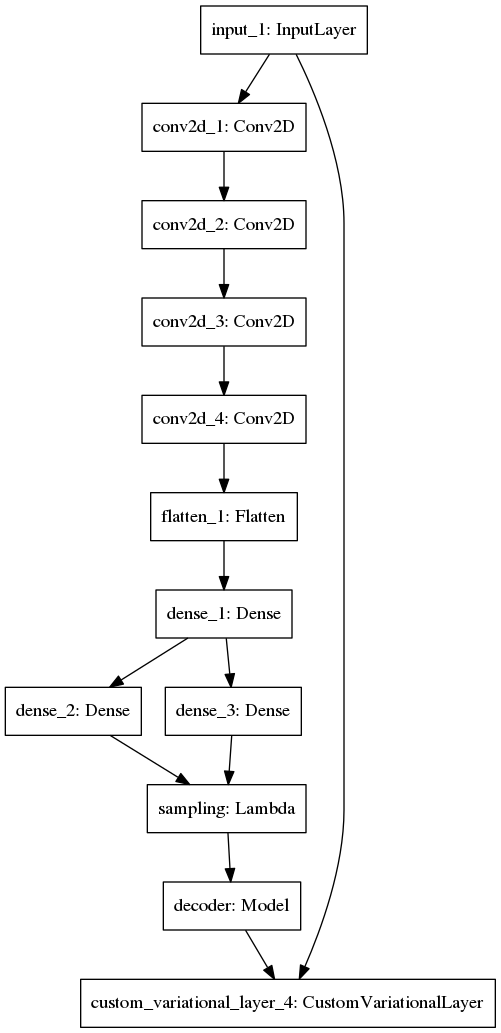

In [34]:
from IPython.display import Image
from keras.utils import plot_model

plot_model(vae, to_file='./plot-model/vae.png')
Image(filename='./plot-model/vae.png')

In [37]:
# MNIST 숫자 이미지에서 VAE를 훈련합니다
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 17s 290us/step - loss: 0.2012 - val_loss: 0.1890
Epoch 2/10
60000/60000 [==============================] - 17s 288us/step - loss: 0.1869 - val_loss: 0.1851
Epoch 3/10
60000/60000 [==============================] - 17s 286us/step - loss: 0.1839 - val_loss: 0.1823
Epoch 4/10
60000/60000 [==============================] - 17s 288us/step - loss: 0.1823 - val_loss: 0.1824
Epoch 5/10
60000/60000 [==============================] - 17s 289us/step - loss: 0.1813 - val_loss: 0.1835
Epoch 6/10
60000/60000 [==============================] - 17s 286us/step - loss: 0.1805 - val_loss: 0.1797
Epoch 7/10
60000/60000 [==============================] - 17s 286us/step - loss: 0.1799 - val_loss: 0.1803
Epoch 8/10
60000/60000 [==============================] - 17s 290us/step - loss: 0.1794 - val_loss: 0.1796
Epoch 9/10
60000/60000 [==============================] - 17s 290us/step - loss: 0.1790 - val_

#### 6) VAE 디코더 시각화

MNIST 데이터셋으로 모델의 훈련을 마치면 디코더 네트워크를 사용하여 잠재 공간의 임의의 벡터를 이미지로 변환할 수 있습니다:

In [38]:
import matplotlib.pyplot as plt

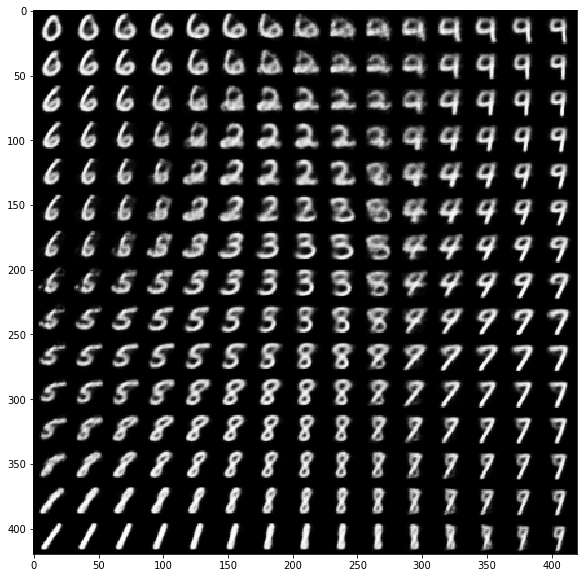

In [39]:
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 15  # 15 × 15 숫자의 그리드를 출력합니다
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# 싸이파이 ppf 함수를 사용하여 일정하게 떨어진 간격마다 잠재 변수 z의 값을 만듭니다
# 잠재 공간의 사전 확률은 가우시안입니다
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

샘플링된 숫자의 그리드는 다른 숫자 클래스 사이에서 완벽하게 연속된 분포를 보여줍니다. 잠재 공간의 한 경로를 따라서 한 숫자가 다른 숫자로 자연스럽게 바뀝니다. 이 공간의 특정 방향은 어떤 의미를 가집니다. 예를 들어 '6으로 가는 방향', '9로 가는 방향' 등입니다.